<a href="https://colab.research.google.com/github/mattattabi78/CheVi/blob/main/chess.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install chess
import chess

In [ ]:
import os
import copy

import pickle
import numpy as np

import torch
import torch.nn as nn
import torch.nn.functional as F

from tqdm import tqdm
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Data archtecture

In [ ]:
from torch.utils.data import Dataset, DataLoader

In [ ]:
class ChessSeqDataset(Dataset):
  def __init__(self, games, seq_len=3):
    """
    games: list of Tensor. each tensor shape(game_len, 12, 8, 8)
    seq_len: number of input frames
    output: "state" or "diff"
    """

    self.games = games
    self.seq_len = seq_len


    self.index = [] #(game_idx, start_t)
    for game_idx, game in enumerate(games):
      L = game.shape[0]
      for start_t in range(L - seq_len):
        self.index.append((game_idx, start_t))

  def __len__(self):
    return len(self.index)

  def __getitem__(self, idx):
    game_idx, start_t = self.index[idx]

    game = self.games[game_idx]
    X = game[start_t: start_t + self.seq_len] #shape: (seq_len, 12, 8, 8)

    prev_state = game[start_t + self.seq_len - 1]      # (12, 8, 8)
    next_state = game[start_t + self.seq_len]          # (12, 8, 8)

    changed = (prev_state != next_state).float()        # (12, 8, 8)

    # from = 말이 있던 칸이 없어짐
    Y_peice = (prev_state == 1) & (next_state == 0)  # (12, 8, 8)
    Y_peice = Y_peice.any(dim=0).float()    # (8, 8)

    # to = 말이 없던 칸에 생김
    Y_move = (prev_state == 0) & (next_state == 1) # (12, 8, 8)
    Y_move = Y_move.any(dim=0).float()     # (8, 8)

    return X, Y_peice, Y_move



# Model Archtecture

In [ ]:
#Patch embedding for each position of board
class PatchEmbedding(nn.Module):
  def __init__(self, in_channels: int = 12, embed_dim: int = 128):
    super().__init__()

    self.proj = nn.Conv2d(in_channels, embed_dim, kernel_size=1, stride=1)

  def forward(self, x: torch.Tensor) -> torch.Tensor:
    # x: (B, C=12, H=8, W=8)
    x = self.proj(x) #shape: (B, E, 8, 8)
    B, E, H, W =x.shape
    x = x.flatten(2).transpose(1, 2) #shape: (B, 64, E)
    return x

In [ ]:
class FromHead(nn.Module):
    def __init__(self, embed_dim):
        super().__init__()
        self.classifier = nn.Sequential(
            nn.Linear(embed_dim, embed_dim),
            nn.ReLU(),
            nn.Linear(embed_dim, 1)   # per-square logit
        )

    def forward(self, x):
        # x: (B, 64, E)
        logits = self.classifier(x).squeeze(-1)  # (B, 64)
        return logits


class ToHead(nn.Module):
    def __init__(self, embed_dim):
        super().__init__()
        """
        Recive two input:
        x: (B, 64, E) - 전체 보드 embedding
        from_repr: (B, E) - teacher forcing으로 선택된 말의 latent representation
        """

        self.conv_layers = nn.Sequential(

            nn.Conv2d(embed_dim * 2, embed_dim, kernel_size=3, padding=1),
            nn.BatchNorm2d(embed_dim),
            nn.GELU(),

            nn.Conv2d(embed_dim, embed_dim // 2, kernel_size=1),
            nn.GELU(),

            nn.Conv2d(embed_dim // 2, 1, kernel_size=1)
        )

    def forward(self, x, from_repr):
        B, N, E = x.shape

        board_map = x.permute(0, 2, 1).view(B, E, 8, 8) #(B, 64, E) -> (B, E, 8, 8)

        from_map = from_repr.view(B, E, 1, 1).expand(B, E, 8, 8) #Broadcasting

        x_input = torch.cat([board_map, from_map], dim=1)

        logits = self.conv_layers(x_input) # (B, 1, 8, 8)

        return logits.flatten(1) #(B, 64)



class SpaceTimeTransformer(nn.Module):
    def __init__(self,
                 in_channels: int = 12,
                 embed_dim: int = 128,
                 depth: int = 6,
                 num_heads: int = 8,
                 seq_len: int = 3,
                 dropout: float = 0.0):
        super().__init__()
        self.seq_len = seq_len
        self.patch = PatchEmbedding(in_channels=in_channels, embed_dim=embed_dim)

        # board positional embeddings
        self.spatial_pos = nn.Parameter(torch.randn(1, 64, embed_dim))
        # time positional embeddings.
        self.time_pos = nn.Parameter(torch.randn(1, seq_len, 1, embed_dim))

        encoder_layer = nn.TransformerEncoderLayer(
            d_model=embed_dim,
            nhead=num_heads,
            dim_feedforward=embed_dim * 4,
            dropout=dropout,
            batch_first=True,
            activation='gelu'
        )
        self.encoder = nn.TransformerEncoder(encoder_layer, num_layers=depth)

        self.predict_peice = FromHead(embed_dim)  # (B,64,1)
        self.predict_move = ToHead(embed_dim)   # (B,64,1)

        # initialization of parameter
        nn.init.trunc_normal_(self.spatial_pos, std=0.02)
        nn.init.trunc_normal_(self.time_pos, std=0.02)
        self.embed_dim = embed_dim

    def forward(self, x: torch.Tensor, target_from_idx: torch.Tensor = None) -> tuple:
        B, T, C, H, W = x.shape #(32, 3, 12, 8, 8)
        assert T == self.seq_len, f"Expected T={self.seq_len}, got {T}"

        # embed each frame -> (B, 64, E)
        toks = []
        for t in range(T):
            frame = x[:, t]            # (B,12,8,8)
            t_tok = self.patch(frame)  # (B,64,E)
            # add spatial and time pos
            t_tok = t_tok + self.spatial_pos  # broadcast (1,64,E)
            t_tok = t_tok + self.time_pos[:, t]  # (1,1,E) -> broadcast to (B,64,E)
            toks.append(t_tok)

        # concat along token dim: (B, T*64, E)
        tokens = torch.cat(toks, dim=1)
        h = self.encoder(tokens)   # (B, T*64, E)

        last_board_emb = h[:, -64:, :]   #Last board state with embedded by self-attention (B, 64, E)

        #predict peice
        peice_logits = self.predict_peice(last_board_emb)   # (B, 64)
        batch_indices = torch.arange(B, device=x.device)

        #teacher forcing
        if self.training and target_from_idx is not None:
            selected_idx = target_from_idx.long()
        else:
            selected_idx = torch.argmax(peice_logits, dim=-1) # (B,)


        selected_from_repr = last_board_emb[batch_indices, selected_idx]
        move_logits = self.predict_move(last_board_emb, selected_from_repr)

        return peice_logits, move_logits

# Define or Load Model

In [ ]:
import torch.optim as optim
import matplotlib.pyplot as plt

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

BATCH_SIZE = 32
LEARNING_RATE = 1e-4
EPOCHS = 10
SEQ_LEN = 3
EMBED_DIM = 256
NUM_LAYERS = 12
NUM_HEADS = 8


model = SpaceTimeTransformer(
    in_channels=12,
    embed_dim=EMBED_DIM,
    depth=NUM_LAYERS,
    num_heads=NUM_HEADS,
    seq_len=SEQ_LEN,
    dropout=0.2
).to(device)

criterion = nn.CrossEntropyLoss(label_smoothing=0.1)
optimizer = optim.AdamW(model.parameters(), lr=LEARNING_RATE)

def count_params(module):
    return sum(p.numel() for p in module.parameters() if p.requires_grad)


print(f"Total trainable params: {count_params(model):,}")


Using device: cuda
Total trainable params: 10,777,090


In [ ]:
import random
dataset_list = []

for i in tqdm(range(5)):
  dataset_path = f"YOUR DATA PATH"

  with open(dataset_path, "rb") as f:
      dataset = pickle.load(f)
      dataset_list += dataset

random.shuffle(dataset_list)

split_idx = int(len(dataset_list) * 0.9)
new_train_list = dataset_list[:split_idx]
new_valid_list = dataset_list[split_idx:]

print(f"New Train size: {len(new_train_list)} games")
print(f"New Valid size: {len(new_valid_list)} games ")


train_data = ChessSeqDataset(new_train_list, seq_len=SEQ_LEN)
valid_data = ChessSeqDataset(new_valid_list, seq_len=SEQ_LEN)

train_loader = DataLoader(train_data, batch_size=BATCH_SIZE, shuffle=True)
valid_loader = DataLoader(valid_data, batch_size=BATCH_SIZE, shuffle=True)

100%|██████████| 5/5 [02:14<00:00, 26.94s/it]


New Train size: 45000 games
New Valid size: 5000 games 


In [ ]:
# # dummy data
# train_data = ChessSeqDataset(new_train_list, seq_len=SEQ_LEN)
# valid_data = ChessSeqDataset(new_valid_list, seq_len=SEQ_LEN)

# train_data = torch.utils.data.Subset(train_data, range(len(train_data)//1000))
# valid_data = torch.utils.data.Subset(valid_data, range(len(valid_data)//1000))

# print(f"New Train size: {len(train_data)} games")
# print(f"New Valid size: {len(valid_data)} games ")


#
# train_loader = DataLoader(train_data, batch_size=BATCH_SIZE, shuffle=True)
# valid_loader = DataLoader(valid_data, batch_size=BATCH_SIZE, shuffle=True)

In [ ]:


SAVE_DIR = 'YOUR MODEL PATH'

checkpoint = torch.load(SAVE_DIR, map_location=device)

print(f"모델 로드 성공! (저장된 성능 - Loss: {checkpoint['loss']:.4f}, Move Acc: {checkpoint['acc_move']:.2%})")

BATCH_SIZE = 32
LEARNING_RATE = 2e-5
EPOCHS = 15
SEQ_LEN = 3
EMBED_DIM = 256
NUM_LAYERS = 12
NUM_HEADS = 8

model = SpaceTimeTransformer(
    in_channels=12,
    embed_dim=EMBED_DIM,
    depth=NUM_LAYERS,
    num_heads=NUM_HEADS,
    seq_len=SEQ_LEN,
    dropout=0.2
).to(device)
optimizer = optim.AdamW(model.parameters(), lr=LEARNING_RATE)

model.load_state_dict(checkpoint['model_state_dict'])
for param_group in optimizer.param_groups:
        param_group['lr'] = LEARNING_RATE

optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
start_epoch = checkpoint['epoch']


criterion = nn.CrossEntropyLoss(label_smoothing=0.2)
saved_best_valid_loss = checkpoint['loss']

print("Last epoch: ", start_epoch)
print("Last valid loss: ", saved_best_valid_loss)

모델 로드 성공! (저장된 성능 - Loss: 5.3014, Move Acc: 49.72%)
Last epoch:  15
Last valid loss:  5.301358980952911


#Training loop

Start Training...


Epoch 13/15: 100%|██████████| 117617/117617 [1:44:40<00:00, 18.73it/s, loss=4.4432, acc_P=46.7%, acc_M=46.7%]


Epoch [13/15]
  Train - Loss: 4.2666 | Acc Piece: 57.37% | Acc Move: 64.48%
  Valid - Loss: 5.2988 | Acc Piece: 58.70% | Acc Move: 49.53%
  >> Saved to /content/drive/MyDrive/손정우/cv_final/model/final_chess_model.pt
------------------------------------------------------------


Epoch 14/15: 100%|██████████| 117617/117617 [1:44:43<00:00, 18.72it/s, loss=4.1929, acc_P=46.7%, acc_M=73.3%]


Epoch [14/15]
  Train - Loss: 4.2556 | Acc Piece: 57.62% | Acc Move: 64.73%
  Valid - Loss: 5.3637 | Acc Piece: 58.57% | Acc Move: 49.39%
  >> Saved to /content/drive/MyDrive/손정우/cv_final/model/final_chess_model.pt
------------------------------------------------------------


Epoch 15/15: 100%|██████████| 117617/117617 [1:44:44<00:00, 18.72it/s, loss=4.5350, acc_P=53.3%, acc_M=40.0%]


Epoch [15/15]
  Train - Loss: 4.2456 | Acc Piece: 57.77% | Acc Move: 64.96%
  Valid - Loss: 5.3014 | Acc Piece: 58.72% | Acc Move: 49.72%
  >> Saved to /content/drive/MyDrive/손정우/cv_final/model/final_chess_model.pt
------------------------------------------------------------
Training Finished.


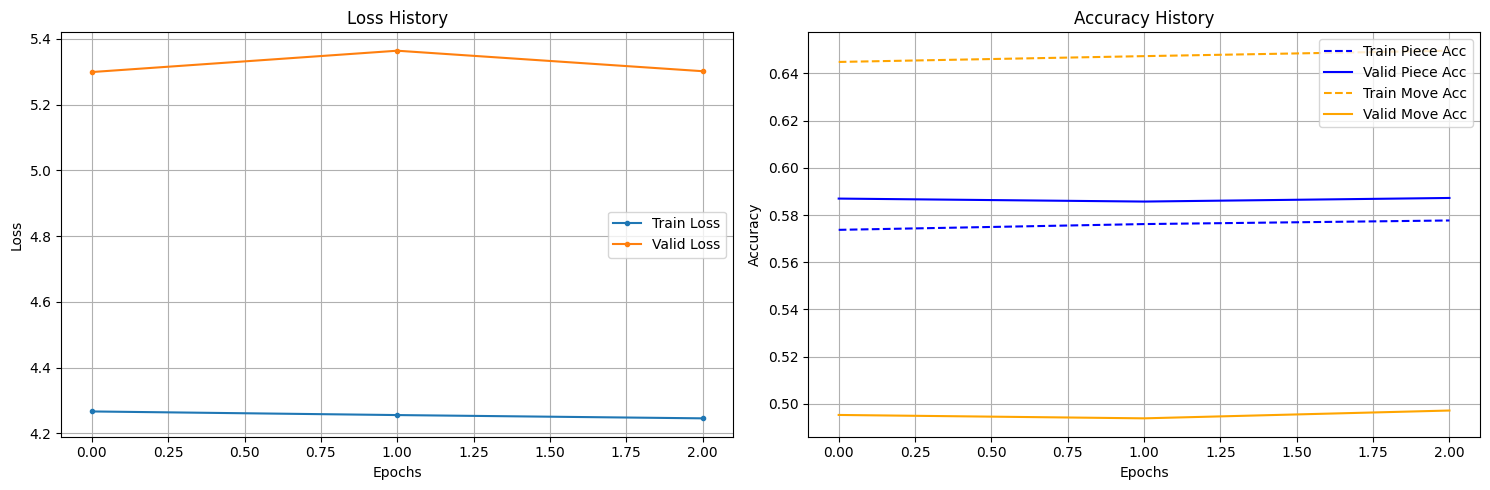

In [ ]:


# Loss history
train_loss_history = []
valid_loss_history = []

# Accuracy history
train_acc_peice_history = []
train_acc_move_history = []
valid_acc_peice_history = []
valid_acc_move_history = []

SAVE_DIR = 'YOUR MODEL PATH'
os.makedirs(SAVE_DIR, exist_ok=True)
BEST_MODEL_PATH = os.path.join(SAVE_DIR, 'best_chess_model.pt')
FINAL_MODEL_PATH = os.path.join(SAVE_DIR, 'final_chess_model.pt')

best_valid_loss = saved_best_valid_loss
best_valid_acc_move = 0.0

print("Start Training...")


for epoch in range(start_epoch, EPOCHS):


    model.train()
    train_total_loss = 0.0
    train_correct_peice = 0
    train_correct_move = 0
    train_total_samples = 0

    teacher_forcing_ratio = max(0.5, 1.0 - (epoch / (EPOCHS * 0.8)))

    progress_bar = tqdm(train_loader, desc=f"Epoch {epoch+1}/{EPOCHS}")

    for batch_idx, (x, y_peice, y_move) in enumerate(progress_bar):
        x = x.to(device) #(B, 3, 12, 8, 8)
        y_peice = y_peice.to(device)
        y_move = y_move.to(device)

        B = x.size(0)

        target_peice_idx = torch.argmax(y_peice.view(B, -1), dim=-1) # (B,)
        target_move_idx  = torch.argmax(y_move.view(B, -1), dim=-1)  # (B,)

        use_teacher_forcing = True if random.random() < teacher_forcing_ratio else False

        if use_teacher_forcing:
          peice_logits, move_logits = model(x, target_from_idx=target_peice_idx)
        else:
          peice_logits, move_logits = model(x, target_from_idx=None)


        loss_peice = criterion(peice_logits, target_peice_idx)
        loss_move  = criterion(move_logits, target_move_idx)
        loss = loss_peice + loss_move

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        train_total_loss += loss.item()


        pred_peice_idx = torch.argmax(peice_logits, dim=-1)
        pred_move_idx  = torch.argmax(move_logits, dim=-1)


        train_correct_peice += (pred_peice_idx == target_peice_idx).sum().item()
        train_correct_move  += (pred_move_idx == target_move_idx).sum().item()
        train_total_samples += B


        curr_acc_p = (pred_peice_idx == target_peice_idx).float().mean().item()
        curr_acc_m = (pred_move_idx == target_move_idx).float().mean().item()
        progress_bar.set_postfix({'loss': f"{loss.item():.4f}", 'acc_P': f"{curr_acc_p:.1%}", 'acc_M': f"{curr_acc_m:.1%}"})


    avg_train_loss = train_total_loss / len(train_loader)
    avg_train_acc_peice = train_correct_peice / train_total_samples
    avg_train_acc_move  = train_correct_move / train_total_samples

    train_loss_history.append(avg_train_loss)
    train_acc_peice_history.append(avg_train_acc_peice)
    train_acc_move_history.append(avg_train_acc_move)


    model.eval()
    valid_total_loss = 0.0

    valid_correct_peice = 0
    valid_correct_move = 0
    valid_total_samples = 0

    with torch.no_grad():
        for x, y_peice, y_move in valid_loader:
            x = x.to(device)
            y_peice = y_peice.to(device)
            y_move = y_move.to(device)
            B = x.size(0)

            target_peice_idx = torch.argmax(y_peice.view(B, -1), dim=-1)
            target_move_idx  = torch.argmax(y_move.view(B, -1), dim=-1)


            peice_logits, move_logits = model(x, target_from_idx=None)

            loss_peice = criterion(peice_logits, target_peice_idx)
            loss_move  = criterion(move_logits, target_move_idx)
            loss = loss_peice + loss_move

            valid_total_loss += loss.item()

            pred_peice_idx = torch.argmax(peice_logits, dim=-1)
            pred_move_idx  = torch.argmax(move_logits, dim=-1)

            valid_correct_peice += (pred_peice_idx == target_peice_idx).sum().item()
            valid_correct_move  += (pred_move_idx == target_move_idx).sum().item()
            valid_total_samples += B

    avg_valid_loss = valid_total_loss / len(valid_loader)
    avg_valid_acc_peice = valid_correct_peice / valid_total_samples
    avg_valid_acc_move  = valid_correct_move / valid_total_samples

    valid_loss_history.append(avg_valid_loss)
    valid_acc_peice_history.append(avg_valid_acc_peice)
    valid_acc_move_history.append(avg_valid_acc_move)

    print(f"Epoch [{epoch+1}/{EPOCHS}]")
    print(f"  Train - Loss: {avg_train_loss:.4f} | Acc Piece: {avg_train_acc_peice:.2%} | Acc Move: {avg_train_acc_move:.2%}")
    print(f"  Valid - Loss: {avg_valid_loss:.4f} | Acc Piece: {avg_valid_acc_peice:.2%} | Acc Move: {avg_valid_acc_move:.2%}")

    torch.save({
            'epoch': epoch + 1,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'loss': avg_valid_loss,
            'acc_move': avg_valid_acc_move
        }, FINAL_MODEL_PATH)

    print(f"  >> Saved to {FINAL_MODEL_PATH}")


    if avg_valid_loss < best_valid_loss:
        print(f"  >> 🎉 New Best Model! Valid Loss Improved: {best_valid_loss:.4f} -> {avg_valid_loss:.4f}")
        best_valid_loss = avg_valid_loss
        best_valid_acc_move = avg_valid_acc_move

        torch.save({
            'epoch': epoch + 1,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'loss': best_valid_loss,
            'acc_move': best_valid_acc_move
        }, BEST_MODEL_PATH)
        print(f"  >> Saved to {BEST_MODEL_PATH}")

    print("-" * 60)



print("Training Finished.")
plt.figure(figsize=(15, 5))

plt.subplot(1, 2, 1)
plt.plot(train_loss_history, label='Train Loss', marker='.')
plt.plot(valid_loss_history, label='Valid Loss', marker='.')
plt.title('Loss History')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

plt.subplot(1, 2, 2)
plt.plot(train_acc_peice_history, label='Train Piece Acc', linestyle='--', color='blue')
plt.plot(valid_acc_peice_history, label='Valid Piece Acc', linestyle='-', color='blue')
plt.plot(train_acc_move_history, label='Train Move Acc', linestyle='--', color='orange')
plt.plot(valid_acc_move_history, label='Valid Move Acc', linestyle='-', color='orange')

plt.title('Accuracy History')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

# Test it!

In [ ]:
PIECE_MAP = {
    "P": 0, "N": 1, "B": 2, "R": 3, "Q": 4, "K": 5,
    "p": 6, "n": 7, "b": 8, "r": 9, "q": 10, "k": 11
}
def fen_to_tensor(fen):
    """
    input: fen data
    output: tensor of one-hot encoded FEN board state. shape: (12, 8, 8)

    """
    board = chess.Board(fen)
    x = np.zeros((12, 8, 8), dtype=np.float32)

    for square, piece in board.piece_map().items():
        c = PIECE_MAP[piece.symbol()]
        r = 7 - (square // 8)
        f = square % 8
        x[c, r, f] = 1.0

    return torch.tensor(x)

REV_PIECE_MAP = {v: k for k, v in PIECE_MAP.items()}

def tensor_to_fen(tensor):
    """
    input: tensor of shape (12, 8, 8) (0 or 1 values)
    output: FEN string (position part only)
    """
    if isinstance(tensor, torch.Tensor):
        tensor = tensor.detach().cpu().numpy()

    fen_rows = []

    for r in range(8):
        empty_count = 0
        row_str = ""
        for c in range(8):

            pixel_vector = tensor[:, r, c]

            max_idx = np.argmax(pixel_vector)
            max_val = pixel_vector[max_idx]

            if max_val < 0.5:
                empty_count += 1
            else:

                if empty_count > 0:
                    row_str += str(empty_count)
                    empty_count = 0

                piece_char = REV_PIECE_MAP[max_idx]
                row_str += piece_char

        if empty_count > 0:
            row_str += str(empty_count)

        fen_rows.append(row_str)


    return "/".join(fen_rows) + " w - - 0 1"

In [ ]:
#보드 상태를 chess.Board() 형식으로 바꾸는 함수
def apply_move_to_board(current_board, pred_from_mask, pred_to_mask):
    """
    current_board: (12, 8, 8) - 현재 보드 상태 (One-hot)
    pred_from_mask: (8, 8) - 출발 위치 마스크 (0 or 1)
    pred_to_mask: (8, 8) - 도착 위치 마스크 (0 or 1)

    return: next_board (12, 8, 8)
    """
    # 1. 좌표 찾기 (nonzero 사용)
    from_coords = torch.nonzero(pred_from_mask, as_tuple=False)
    to_coords = torch.nonzero(pred_to_mask, as_tuple=False)

    if len(from_coords) == 0:
        print("[Warning] 출발 위치가 선택되지 않았습니다.")
        return current_board.clone()
    if len(to_coords) == 0:
        print("[Warning] 도착 위치가 선택되지 않았습니다.")
        return current_board.clone()

    alphabet = ["a", "b", "c", "d", "e", "f", "g", "h"]
    fy, fx = from_coords[0]
    ty, tx = to_coords[0]

    print(f"이동 감지: ({alphabet[fx]}{8-fy}) -> ({alphabet[tx]}{8-ty})")

    # 2. 출발지에 있는 기물(Channel Index) 찾기
    # current_board[:, fy, fx] -> (12,) 벡터
    piece_vec = current_board[:, fy, fx]
    piece_indices = torch.nonzero(piece_vec, as_tuple=False)

    if len(piece_indices) == 0:
        print(f"[Error] 출발 위치 ({fy}, {fx})에 기물이 없습니다! (빈 칸을 옮기려 함)")
        return current_board.clone()

    piece_idx = piece_indices[0].item() # 예: 0(폰), 4(퀸) 등

    next_board = current_board.clone()

    next_board[:, fy, fx] = 0

    next_board[:, ty, tx] = 0

    next_board[piece_idx, ty, tx] = 1.0

    return next_board


In [ ]:
#샘플링 함수
def get_sampled_prediction(prediction_tensor, k=3):
        prediction_tensor = prediction_tensor.view(-1) #remove batch

        top_val, top_indices = torch.topk(prediction_tensor, k=k)

        top_probs = F.softmax(top_val, dim=-1)

        sample_idx_in_top_k = torch.multinomial(top_probs, 1) # 각 로짓 확률에 기반한 뽑기

        actual_index = top_indices[sample_idx_in_top_k]

        output_tensor = torch.zeros_like(prediction_tensor)
        output_tensor[actual_index] = 1.0
        return actual_index, output_tensor.view(8, 8)

In [ ]:
def do_chess(FEN_list):

  """
  Board data: sequence of board data. shape(seq_length, 12, 8, 8)

  """
  FEN_list = FEN_list[-3:]
  X = []
  for i in range(3):
    X.append(fen_to_tensor(FEN_list[i]))

  current_board = X[-1]  # 사용자의 원본 보드

  #설계를 잘못해서 샘플링을 위한 모델의 foward부분을 구현함
  x = torch.stack(X).unsqueeze(0).to(device)
  B, T, C, H, W = x.shape #(B=1)

  # embed each frame -> (B, 64, E)
  toks = []
  for t in range(T):
      frame = x[:, t]            # (1,12,8,8)
      t_tok = model.patch(frame)  # (1,64,E)
      # add spatial and time pos
      t_tok = t_tok + model.spatial_pos  # broadcast (1,64,E)
      t_tok = t_tok + model.time_pos[:, t]
      toks.append(t_tok)

  # concat along token dim: (1, T*64, E)
  tokens = torch.cat(toks, dim=1)
  h = model.encoder(tokens)   # (1, T*64, E)

  last_board_emb = h[:, -64:, :]   #Last board state with embedded by self-attention (B, 64, E)

  #predict peice
  peice_logits = model.predict_peice(last_board_emb)

  selected_idx, pred_peice = get_sampled_prediction(peice_logits, k=8)

  #predict move
  batch_indices = torch.arange(B, device=x.device)
  selected_from_repr = last_board_emb[batch_indices, selected_idx]

  move_logits = model.predict_move(last_board_emb, selected_from_repr)
  _, pred_move = get_sampled_prediction(move_logits, k=3)



  next_state_Y = apply_move_to_board(current_board, pred_peice, pred_move)

  prev_fen = tensor_to_fen(current_board)
  next_fen = tensor_to_fen(next_state_Y)

  FEN_list.append(next_fen)

  return FEN_list

In [ ]:
def user_turn(FEN_list, start_pos, end_pos):
    """
    FEN_list: 현재까지의 게임 기록이 담긴 리스트
    start_pos: 출발 위치 문자열 (예: "e2")
    end_pos: 도착 위치 문자열 (예: "e4")

    return: 업데이트된 FEN_list
    """
    current_fen = FEN_list[-1]
    board = chess.Board(current_fen)

    move_str = (start_pos + end_pos).strip().lower()

    try:
        move = chess.Move.from_uci(move_str)
    except ValueError:
        print(f"Format Error: {move_str}")
        return FEN_list, False

    # 3. 유효한 수인지 검증 (Legal Move Check)
    if move not in board.legal_moves:

      print(f"Illegal Move: {move_str}")
      return FEN_list, False

    board.push(move)

    next_fen = board.fen()
    FEN_list.append(next_fen)

    return FEN_list, True

In [ ]:
FEN_list = []
model.eval()
init = valid_data[120][0] #(3, 12, 8, 8)

for i in range(3):
  fen = tensor_to_fen(init[i])
  FEN_list.append(fen)


이동 감지: (f4) -> (f4)




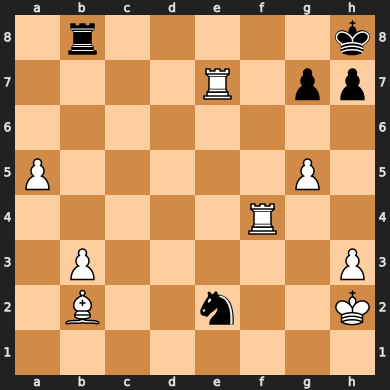

In [ ]:
#white: user | black: chess Model
legal = True

start = "d7"
end = "e7"
#lol
FEN_list, legal = user_turn(FEN_list, start, end)

if legal:
  FEN_list = do_chess(FEN_list)
  print("\n")

display(chess.Board(FEN_list[-1]))